In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("dataset/ai_job_market_2025.csv")
df.head()
df.shape, df.columns

((15000, 19),
 Index(['job_id', 'job_title', 'salary_usd', 'salary_currency',
        'experience_level', 'employment_type', 'company_location',
        'company_size', 'employee_residence', 'remote_ratio', 'required_skills',
        'education_required', 'years_experience', 'industry', 'posting_date',
        'application_deadline', 'job_description_length', 'benefits_score',
        'company_name'],
       dtype='object'))

# Analisi del mercato del lavoro AI (2024-2025)

## Obiettivo del progetto
Questo progetto analizza l'evoluzione recente delle offerte di lavoro nel settore
dell'Intelligenza Artificiale nel periodo 2024-2025. L'analisi prende in esame
i trend temporali, la distribuzione geografica delle offerte, i ruoli professionali
piu richiesti, le competenze tecniche richieste, le differenze salariali e la
diffusione del lavoro remoto.

## Fonte dei dati
Il dataset utilizzato è "AI & Data Job Salaries and Skills Dataset 2024-2025",
disponibile sulla piattaforma Kaggle (autore: Pratyush Puri).
Il dataset è di tipo sintetico ed è progettato per l'analisi dei trend del mercato
del lavoro AI a livello globale nel periodo considerato.

## 1) Evoluzione temporale delle offerte di lavoro AI (2024–2025)
**Domande di ricerca**
- Quante offerte di lavoro AI sono presenti nel 2024 e nel 2025?
- Come varia il numero di offerte tra i due anni? Si osserva una crescita o una diminuzione?

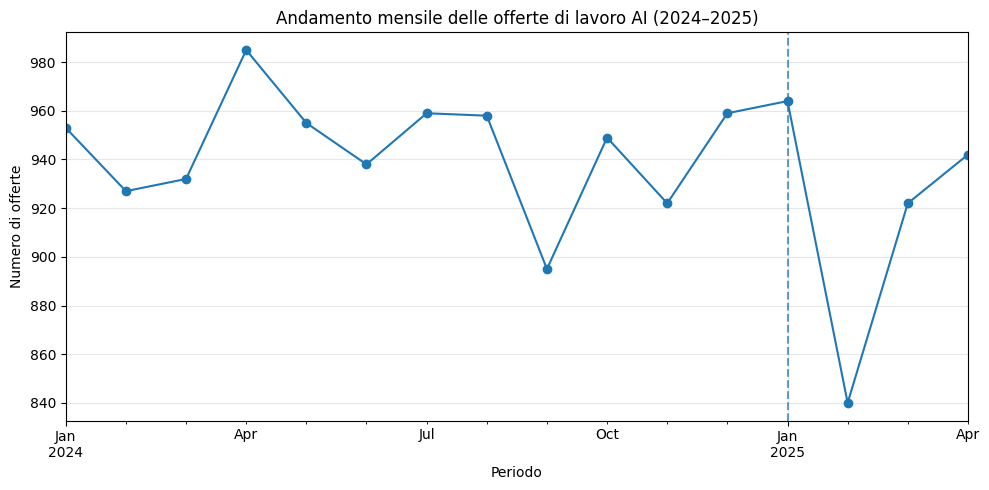

,year,Numero offerte
0,2024,11332
1,2025,3668


,Confronto,Variazione % (a parità di tempo)
0,2025 vs 2024,-1.28


In [3]:
# parsing data
df["posting_date"] = pd.to_datetime(df["posting_date"], errors="coerce")
df = df.dropna(subset=["posting_date"])

# estrazione anno e anno-mese
df["year"] = df["posting_date"].dt.year
df = df[df["year"].isin([2024, 2025])]

df["year_month"] = df["posting_date"].dt.to_period("M")

# Andamento mensile nel periodo
offers_per_month = (
    df.groupby("year_month")
    .size()
    .sort_index()
)

plt.figure(figsize=(10,5))
offers_per_month.plot(kind="line", marker="o")

plt.axvline(pd.Period("2025-01", freq="M"), linestyle="--", alpha=0.7)

plt.title("Andamento mensile delle offerte di lavoro AI (2024–2025)")
plt.xlabel("Periodo")
plt.ylabel("Numero di offerte")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Variaz % 2024 vs 2025
coverage = df.groupby("year")["posting_date"].agg(
    start_date="min",
    end_date="max",
    num_records="count"
)

coverage["days_covered"] = (coverage["end_date"] - coverage["start_date"]).dt.days + 1
coverage["offers_per_day"] = coverage["num_records"] / coverage["days_covered"]

variation_time_adjusted = (
    (coverage.loc[2025, "offers_per_day"] - coverage.loc[2024, "offers_per_day"])
    / coverage.loc[2024, "offers_per_day"]
) * 100

offers_per_year = df.groupby("year").size().reset_index(name="Numero offerte")
display(offers_per_year)

# tabella YoY
rq1_yoy = pd.DataFrame({
    "Confronto": ["2025 vs 2024"],
    "Variazione % (a parità di tempo)": [round(variation_time_adjusted, 2)]
})

display(rq1_yoy)

Si noti che per il 2025 i dati sono disponibili solo fino al mese di aprile; per questo motivo il confronto percentuale tra anni è stato normalizzato rispetto al numero medio di offerte giornaliere.

## 2) Distribuzione geografica delle offerte di lavoro AI (2024–2025)
**Domande di ricerca**
- Quante offerte di lavoro AI sono presenti in ogni Paese?
- Qual è la precentuale di incidenza dei to 10 paesi sul totale globale?
- Andamento mensile dei top 10 paesi con più offerte di lavoro nel settore AI

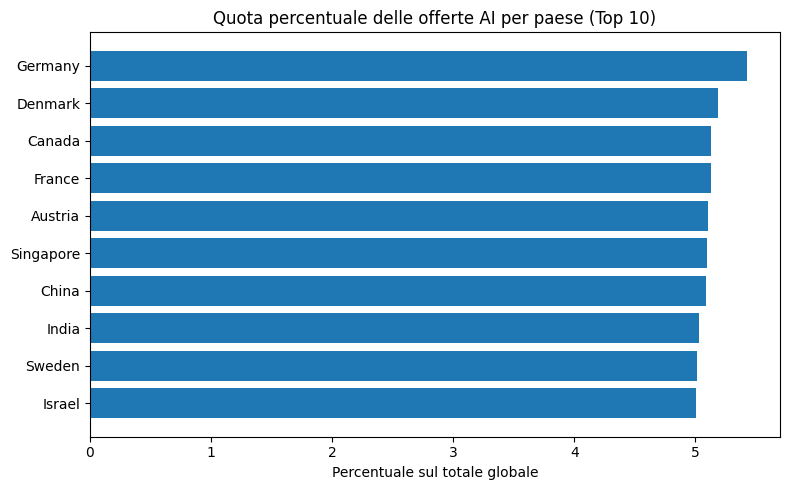

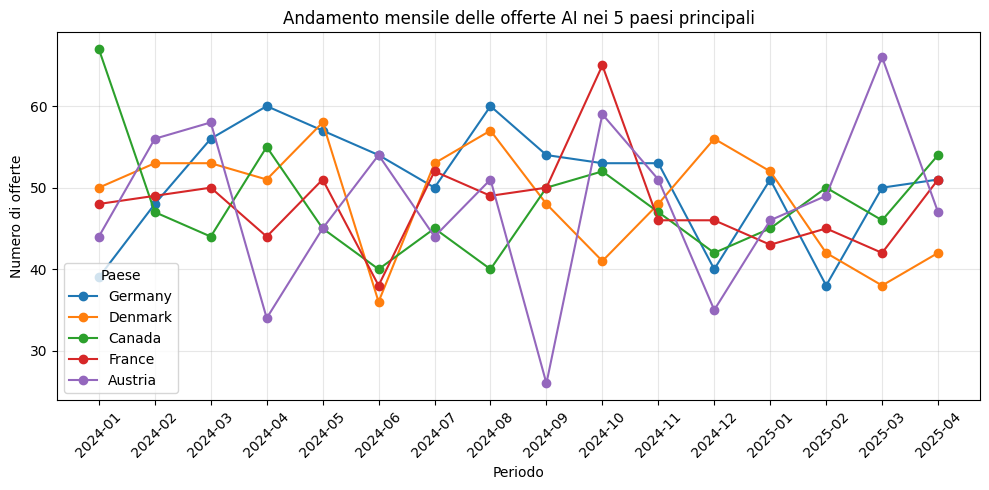

In [4]:
import plotly.express as px

# Preparazione dati geografici

# colonna paese
country_col = "company_location" if "company_location" in df.columns else "country"

# anno-mese per analisi temporale
df["year_month"] = df["posting_date"].dt.to_period("M")

# CHOROPLETH MAP — numero totale offerte per paese

offers_by_country = (
    df.groupby(country_col)
    .size()
    .reset_index(name="offers")
)

fig_map = px.choropleth(
    offers_by_country,
    locations=country_col,
    locationmode="country names",
    color="offers",
    hover_name=country_col,
    color_continuous_scale="Blues",
    title="Distribuzione globale delle offerte AI (totale periodo)"
)

fig_map.show()

# Bar chart % sul totale globale

offers_by_country["percentage"] = (
    offers_by_country["offers"] / offers_by_country["offers"].sum() * 100
)

top_percent = (
    offers_by_country
    .sort_values("percentage", ascending=False)
    .head(10)
)

plt.figure(figsize=(8,5))
plt.barh(top_percent[country_col], top_percent["percentage"])
plt.xlabel("Percentuale sul totale globale")
plt.title("Quota percentuale delle offerte AI per paese (Top 10)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Line plot x andamento mensile per i 5 top paesi

top5_countries = (
    offers_by_country
    .sort_values("offers", ascending=False)
    .head(5)[country_col]
)

monthly_top5 = (
    df[df[country_col].isin(top5_countries)]
    .groupby([country_col, "year_month"])
    .size()
    .reset_index(name="offers")
    .sort_values("year_month")
)

plt.figure(figsize=(10,5))

for country in top5_countries:
    subset = monthly_top5[monthly_top5[country_col] == country]
    plt.plot(subset["year_month"].astype(str), subset["offers"], marker="o", label=country)

plt.xticks(rotation=45)
plt.xlabel("Periodo")
plt.ylabel("Numero di offerte")
plt.title("Andamento mensile delle offerte AI nei 5 paesi principali")
plt.legend(title="Paese")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


La distribuzione ottenuta suggerisce che il dataset non sia pienamente rappresentativo del mercato globale, ma piuttosto orientato verso determinate aree geografiche, probabilmente europee. Questo può dipendere dalla natura sintetica dei dati o dalla fonte di raccolta, e va tenuto in considerazione nell’interpretazione dei risultati.

## 3) Ruoli professionali più richiesti
**Domande di ricerca**
- Quali sono i ruoli professionali più richiesti nel settore AI in base alle offerte totali?
- Come varia la domanda dei top 10 ruoli tra l’inizio del 2024 e l’inizio del 2025?

,Job title,Numero totale offerte
0,machine learning researcher,808
1,ai software engineer,784
2,autonomous systems engineer,777
3,machine learning engineer,772
4,ai architect,771
5,head of ai,765
6,nlp engineer,762
7,robotics engineer,759
8,data analyst,759
9,ai research scientist,756


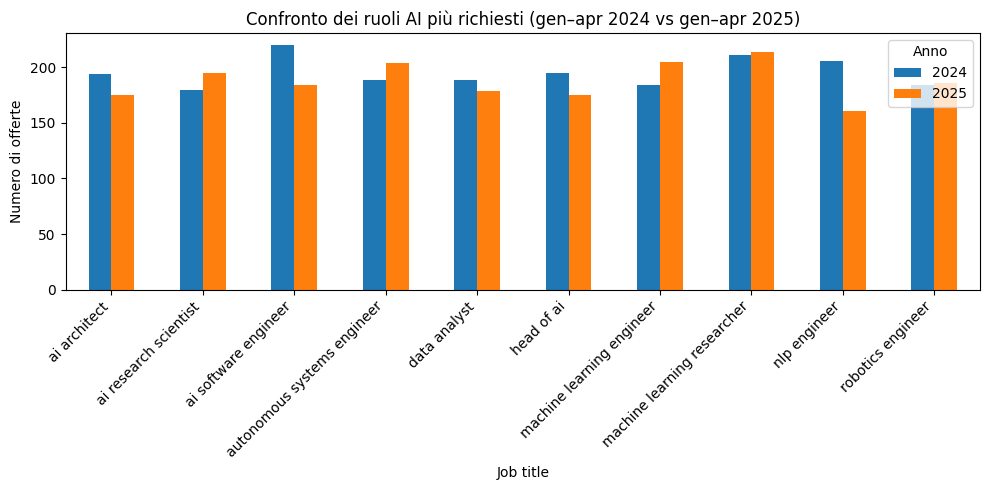

In [5]:
# mi assicuro che posting_date e year siano ok
df["posting_date"] = pd.to_datetime(df["posting_date"], errors="coerce")
df["year"] = df["posting_date"].dt.year
df = df.dropna(subset=["posting_date", "year"])
df["year"] = df["year"].astype(int)

# Filtro temporale: mesi comuni gennio|aprile
df_rq3 = df[
    ((df["year"] == 2024) & (df["posting_date"].dt.month <= 4)) |
    ((df["year"] == 2025) & (df["posting_date"].dt.month <= 4))
].copy()

# normalizzaz job title
job_col = "job_title"
df_rq3[job_col] = df_rq3[job_col].str.lower().str.strip()
df[job_col] = df[job_col].str.lower().str.strip()

# table numero tot di offerte per ruolo (periodo totale)
total_roles = (
    df[job_col]
    .value_counts()
    .head(10)
    .reset_index()
)

total_roles.columns = ["Job title", "Numero totale offerte"]
display(total_roles)

# seleziono top ruoli dalla tabella
top_roles = total_roles["Job title"]

# conteggio x ruolo e anno (solo gen–apr)
role_year_counts = (
    df_rq3[df_rq3[job_col].isin(top_roles)]
    .groupby([job_col, "year"])
    .size()
    .unstack(fill_value=0)
)

# garantisco colonne numeriche 2024 e 2025 anche se mancano
role_year_counts = role_year_counts.reindex(columns=[2024, 2025], fill_value=0)

# se è vuoto, non plotto (non crasha)
if role_year_counts.shape[0] == 0:
    print("Nessuno dei top 10 ruoli (totale periodo) compare nel sottoinsieme gen–apr 2024/2025.")
else:
    role_year_counts.plot(
        kind="bar",
        figsize=(10,5)
    )

    plt.xlabel("Job title")
    plt.ylabel("Numero di offerte")
    plt.title("Confronto dei ruoli AI più richiesti (gen–apr 2024 vs gen–apr 2025)")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Anno")
    plt.tight_layout()
    plt.show()


## RQ4 — Competenze tecniche più richieste
**Domande di ricerca**
- Quali sono le skill tecniche più richieste nel settore AI considerando l’intero periodo?
- Come varia la domanda delle top 10 competenze tecniche tra inizio 2024 e inizio 2025?

,Skill,Numero totale offerte
0,python,4450
1,sql,3407
2,tensorflow,3022
3,kubernetes,3009
4,scala,2794
5,pytorch,2777
6,linux,2705
7,git,2631
8,java,2578
9,gcp,2442


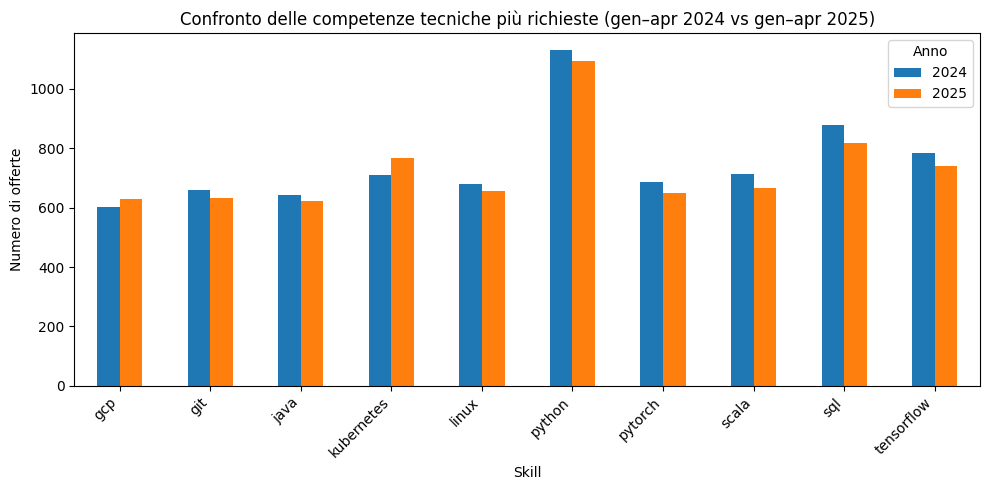

In [6]:
# Table skill più richieste (tot periodo)
skill_col = "required_skills"

df_skills_all = df.copy()

df_skills_all[skill_col] = (
    df_skills_all[skill_col]
    .astype(str)
    .str.lower()
    .str.strip()
    .str.split(r"[,;|]")
)

df_skills_all = df_skills_all.explode(skill_col)
df_skills_all[skill_col] = df_skills_all[skill_col].str.strip()

# Rimuovo vuoti e NaN
df_skills_all = df_skills_all[
    df_skills_all[skill_col].ne("") & df_skills_all[skill_col].ne("nan")
]

total_skills = (
    df_skills_all[skill_col]
    .value_counts()
    .head(10)
    .reset_index()
)

total_skills.columns = ["Skill", "Numero totale offerte"]
display(total_skills)

top_skills = total_skills["Skill"]


# BAR CHART gen–apr 2024 vs gen–apr 2025
df_skills_time = df[
    ((df["year"] == 2024) & (df["posting_date"].dt.month <= 4)) |
    ((df["year"] == 2025) & (df["posting_date"].dt.month <= 4))
].copy()

df_skills_time[skill_col] = (
    df_skills_time[skill_col]
    .astype(str)
    .str.lower()
    .str.strip()
    .str.split(r"[,;|]")
)

df_skills_time = df_skills_time.explode(skill_col)
df_skills_time[skill_col] = df_skills_time[skill_col].str.strip()

# Rimuovo vuoti e NaN
df_skills_time = df_skills_time[
    df_skills_time[skill_col].ne("") & df_skills_time[skill_col].ne("nan")
]

skill_year_counts = (
    df_skills_time[df_skills_time[skill_col].isin(top_skills)]
    .groupby([skill_col, "year"])
    .size()
    .unstack(fill_value=0)
)

skill_year_counts.plot(kind="bar", figsize=(10,5))
plt.xlabel("Skill")
plt.ylabel("Numero di offerte")
plt.title("Confronto delle competenze tecniche più richieste (gen–apr 2024 vs gen–apr 2025)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Anno")
plt.tight_layout()
plt.show()


## RQ5 — Analisi salariale nel settore AI
**Domande di ricerca**
- Come sono distribuiti i salari nel settore AI nei paesi con la mediana più alta?
- Quali sono i ruoli AI con il salario medio più elevato?

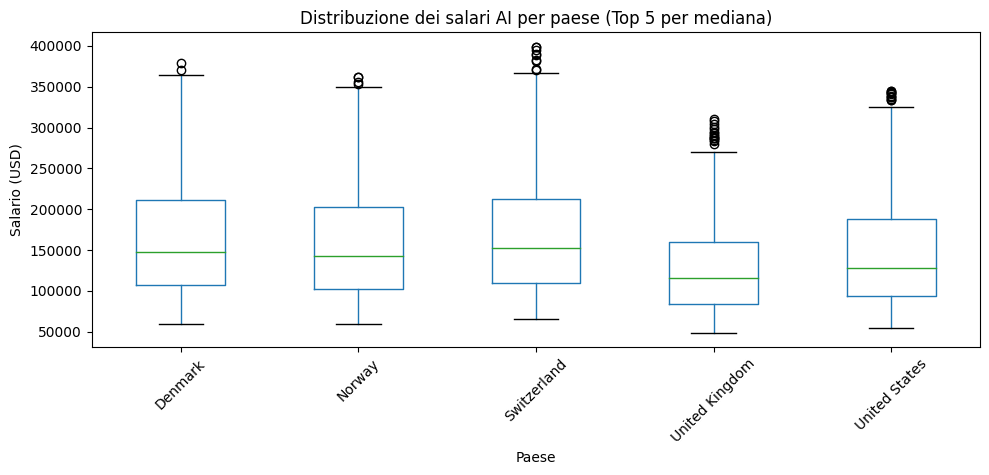

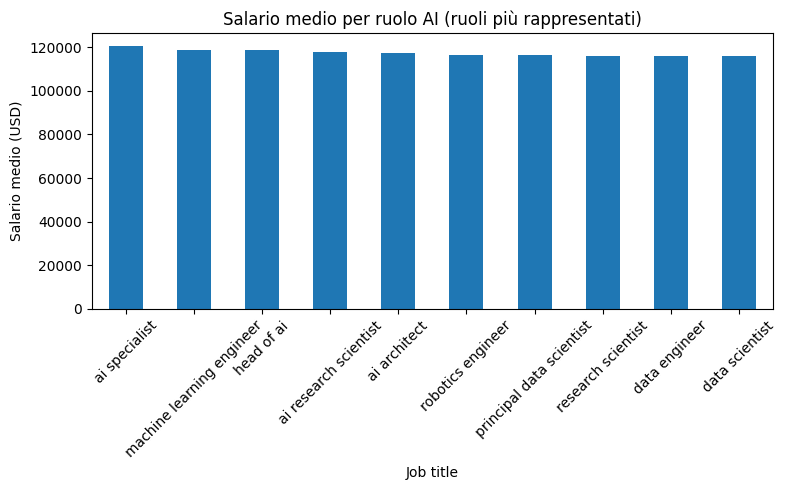

In [7]:
# Preparaz dati salario
salary_col = "salary_usd"
job_col = "job_title"
country_col = "company_location"

# solo righe con salario valido
df_salary = df[df[salary_col].notna()].copy()

# normalizzo job title
df_salary[job_col] = df_salary[job_col].str.lower().str.strip()


# Boxplot salari per paese (Top 5 per mediana)

# calcolo mediana per paese
country_median = (
    df_salary
    .groupby(country_col)[salary_col]
    .median()
    .sort_values(ascending=False)
)

# seleziono top 5
top5_countries = country_median.head(5).index.tolist()

df_top5_countries = df_salary[df_salary[country_col].isin(top5_countries)]

fig, ax = plt.subplots(figsize=(10,5))

df_top5_countries.boxplot(
    column=salary_col,
    by=country_col,
    ax=ax,
    grid=False,
    rot=45,
    showfliers=True
)

ax.set_title("Distribuzione dei salari AI per paese (Top 5 per mediana)")
plt.suptitle("")
ax.set_xlabel("Paese")
ax.set_ylabel("Salario (USD)")
plt.tight_layout()
plt.show()


# Bar chart salario medio x ruolo

MIN_ROLE_POSTINGS = 50

role_salary = (
    df_salary
    .groupby(job_col)
    .filter(lambda x: len(x) >= MIN_ROLE_POSTINGS)
    .groupby(job_col)[salary_col]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

fig, ax = plt.subplots(figsize=(8,5))

role_salary.plot(kind="bar", ax=ax)
ax.set_ylabel("Salario medio (USD)")
ax.set_xlabel("Job title")
ax.set_title("Salario medio per ruolo AI (ruoli più rappresentati)")
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()


## RQ6 — Modalità di lavoro: onsite, hybrid, remote
**Domande di ricerca**
- Qual è la distribuzione globale delle offerte di lavoro AI tra modalità onsite, hybrid e remote?
- Come varia la distribuzione delle modalità di lavoro nei top 5 paesi con più offerte di lavoro AI?
- Come è variata la distribuzione delle modalità di lavoro tra 2024 e 2025 a parità di tempo?

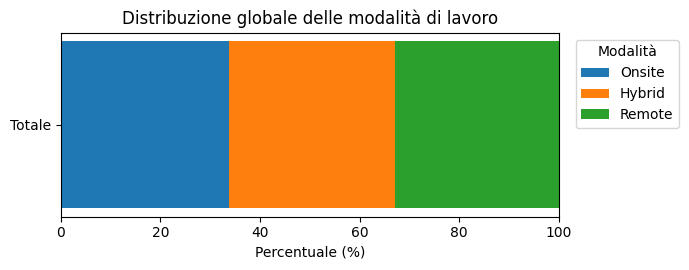

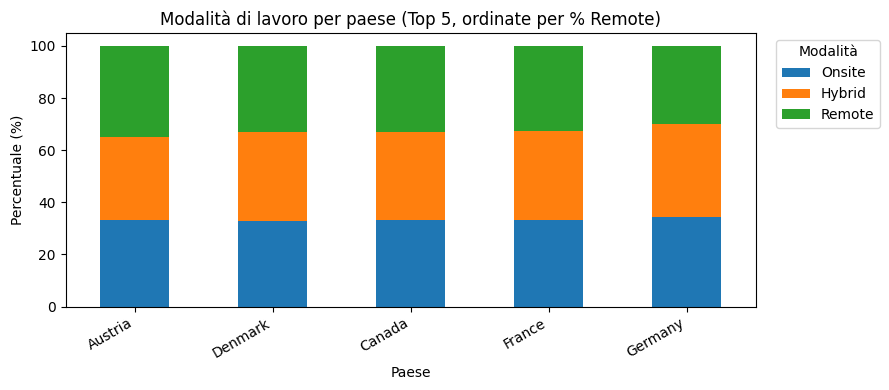

,Modalità,Offerte/giorno 2024,Offerte/giorno 2025,Variazione % (a parità di tempo)
0,Onsite,10.4672,10.3667,-0.96
1,Hybrid,10.3579,10.1167,-2.33
2,Remote,10.1366,10.0833,-0.53


In [8]:
salary_col = "salary_usd"
country_col = "company_location"

df_remote = df.copy()

# mappo remote_ratio in categoria
df_remote["work_mode"] = df_remote["remote_ratio"].map({0: "Onsite", 50: "Hybrid", 100: "Remote"})

# solo valori validi
df_remote = df_remote[df_remote["work_mode"].notna()].copy()

order_modes = ["Onsite", "Hybrid", "Remote"]

# Distribuz globale %
global_pct = (df_remote["work_mode"].value_counts(normalize=True) * 100).reindex(order_modes, fill_value=0)

plt.figure(figsize=(7,2.8))
left = 0
for mode in order_modes:
    plt.barh(["Totale"], [global_pct[mode]], left=left, label=mode)
    left += global_pct[mode]

plt.xlim(0, 100)
plt.xlabel("Percentuale (%)")
plt.title("Distribuzione globale delle modalità di lavoro")
plt.legend(title="Modalità", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Distribuz x paese (Top 5) 

top5 = df_remote[country_col].value_counts().head(5).index

country_pct = (
    df_remote[df_remote[country_col].isin(top5)]
    .groupby([country_col, "work_mode"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .unstack(fill_value=0)
    .reindex(columns=order_modes, fill_value=0)
)

# ordino i paesi per Remote decrescente
country_pct = country_pct.sort_values("Remote", ascending=False)

country_pct.index = country_pct.index.map(lambda x: str(x[0]) if isinstance(x, tuple) else str(x))

ax = country_pct.plot(kind="bar", stacked=True, figsize=(9,4))
plt.ylabel("Percentuale (%)")
plt.xlabel("Paese")
plt.title("Modalità di lavoro per paese (Top 5, ordinate per % Remote)")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Modalità", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Variazione % 2024vs2025 a parità di tempo per work_mode

# coverage x anno: normalizzo sul tempo coperto
coverage_remote = df_remote.groupby("year")["posting_date"].agg(
    start_date="min",
    end_date="max",
    num_records="count"
)

coverage_remote["days_covered"] = (coverage_remote["end_date"] - coverage_remote["start_date"]).dt.days + 1

# conteggio x anno e work_mode
counts_year_mode = (
    df_remote
    .groupby(["year", "work_mode"])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=order_modes, fill_value=0)
)

# normalizzo x giorni coperti (offerte al giorno x modalità)
per_day_year_mode = counts_year_mode.div(coverage_remote["days_covered"], axis=0)

# variazione % 2024vs2025 x ogni modalità a parità di tempo
variation_mode = (
    (per_day_year_mode.loc[2025] - per_day_year_mode.loc[2024])
    / per_day_year_mode.loc[2024]
    * 100
).round(2)

# table
rq6_yoy = pd.DataFrame({
    "Modalità": order_modes,
    "Offerte/giorno 2024": per_day_year_mode.loc[2024, order_modes].round(4).values,
    "Offerte/giorno 2025": per_day_year_mode.loc[2025, order_modes].round(4).values,
    "Variazione % (a parità di tempo)": variation_mode.loc[order_modes].values
})

display(rq6_yoy)


La distribuzione globale delle modalità di lavoro risulta relativamente bilanciata tra onsite, hybrid e remote.  
Una distribuzione simile emerge anche nel confronto tra i principali paesi, suggerendo che nel dataset le modalità di lavoro sono rappresentate in modo uniforme.  
Si segnala che il dataset è di natura sintetica e pertanto non riflette necessariamente le differenze reali.
